# Preamble

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML
import imageio_ffmpeg
import pandas as pd
import seaborn as sns

# %load_ext autoreload
# %autoreload 2

from discretization import create_discretization_element, create_discretization_mesh
from mesh import create_2d_circle, create_2d_square, create_2d_square_structured
from scipy.integrate import solve_ivp
from solver import get_n_element_operators, AdvectionIVPSolver2D

from utils import u_exact_hill, u_exact_hill_dt, f_rhs_hill, advection_velocity_field, get_boundary_normal

In [3]:
plt.rcParams["animation.ffmpeg_path"] = imageio_ffmpeg.get_ffmpeg_exe()

sns.set_theme(style="whitegrid", context="paper")
sns.set_context("poster")

# Results

In [13]:
# Solver parameters
N = 10  # Number of nodes per element
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)
MESH_SIZE = 100  # Target mesh size

# Problem parameters
X_0, Y_0 = -0.75, -0.25
SIGMA = 0.1

t_start = 0.0
t_final = 5.0

In [15]:
mesh_circle = create_2d_circle(radius=DOMAIN_RADIUS, origin=DOMAIN_ORIGIN, mesh_size=MESH_SIZE)
d_ele = create_discretization_element(N)
d_mesh = create_discretization_mesh(mesh_circle, d_ele)
print(f"Total DOFs: {d_mesh.gidx}")

Total DOFs: 5966


In [16]:
solver = AdvectionIVPSolver2D(
    mesh=mesh_circle,
    discretization_element=d_ele,
    discretization_mesh=d_mesh,
    advection_velocity_field=advection_velocity_field,
    g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    f_rhs=f_rhs_hill,
    with_upwind_scheme=True,
)

Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 250.56it/s]


In [17]:
# Set up initial condition
u0 = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0)

t_span = (t_start, t_final, )
n_frames = 300
t_eval = np.linspace(t_start, t_final, n_frames)

sol = solve_ivp(
    fun=solver.get_rhs_IVP,
    t_span=t_span,
    y0=u0,
    t_eval=t_eval,
    method="RK45",  # Explicit Runge-Kutta order 5(4)
    rtol=1e-8,  # Relative tolerance
    atol=1e-11,  # Absolute tolerance
    # max_step=0.0001,  # Limit max step size for accuracy
)

u_sols, t_sols = sol.y.T, sol.t
print(sol.nfev)

73112


# Plotting

### Solution

<>:45: SyntaxWarning: invalid escape sequence '\o'
<>:45: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Bjørn Christie\AppData\Local\Temp\ipykernel_25128\3859221935.py:45: SyntaxWarning: invalid escape sequence '\o'
  plt.savefig("report\output\solution_plot.png", bbox_inches='tight', dpi=400)


Computing Error...
L2 Error at t=1.0: 5.83e-03


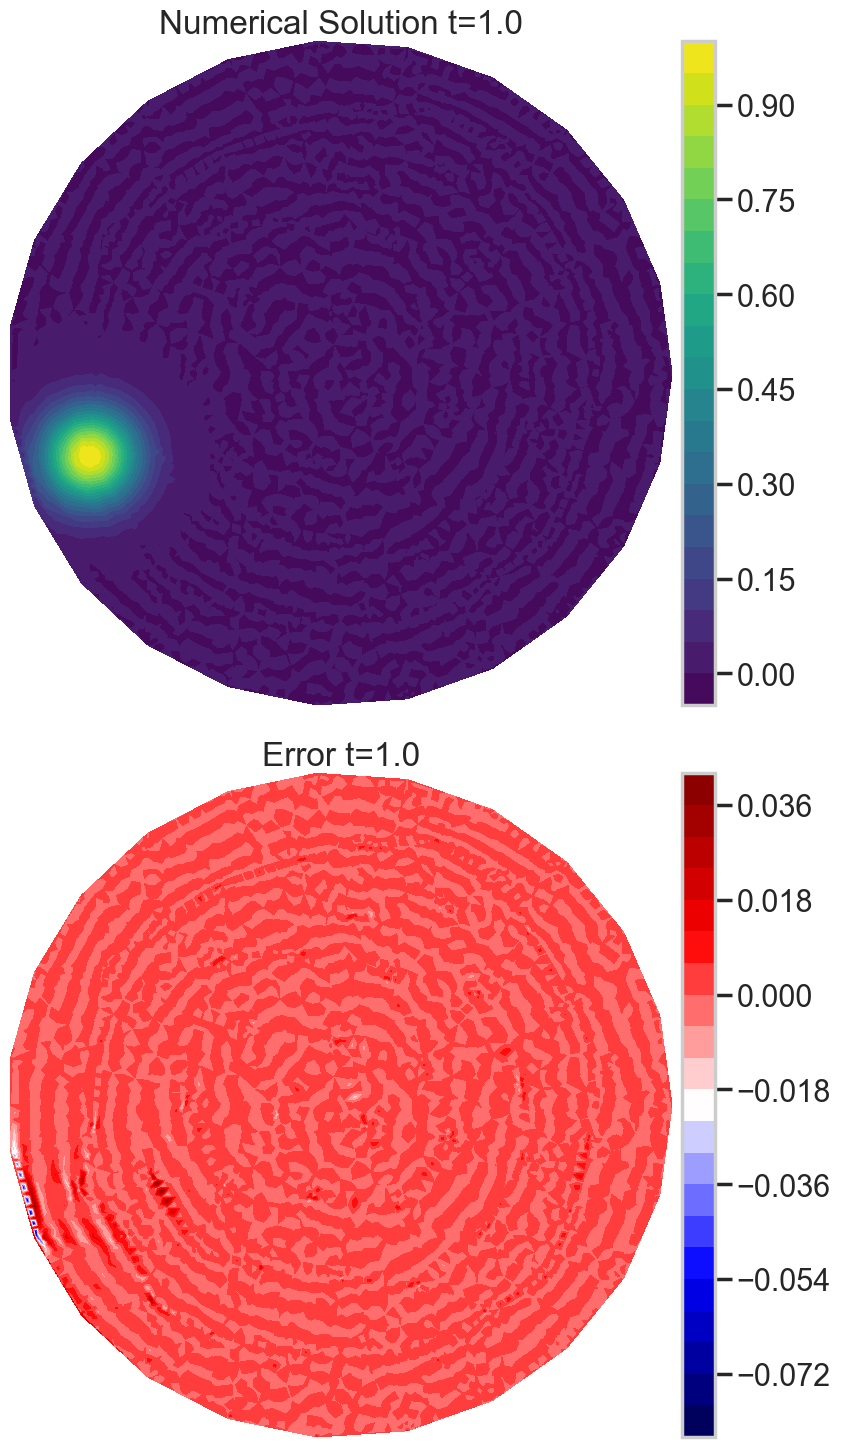

In [11]:
# Compute Error
print("Computing Error...")
final_sol = u_sols[-1]
exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
error = final_sol - exact_sol
L2_err = np.sqrt(error @ (solver.M_global @ error))
print(f"L2 Error at t={t_final}: {L2_err:.2e}")


import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(9.45, 15))

# Triangulation
triang = mpl.tri.Triangulation(d_mesh.x_global, d_mesh.y_global)

# ---------- Left plot ----------
tc1 = axs[0].tricontourf(triang, final_sol, levels=20, cmap="viridis")
axs[0].set_title(f"Numerical Solution t={t_final}")
axs[0].set_aspect("equal")
axs[0].set_axis_off()

# Colorbar for left plot
divider0 = make_axes_locatable(axs[0])
cax1 = divider0.append_axes("right", size="5%", pad=0.1)  # size in % of axis, pad is spacing
fig.colorbar(tc1, cax=cax1)

# ---------- Right plot ----------
tc2 = axs[1].tricontourf(triang, error, levels=20, cmap="seismic")
axs[1].set_title(f"Error t={t_final}")
axs[1].set_aspect("equal")
axs[1].set_axis_off()

# Colorbar for right plot
divider1 = make_axes_locatable(axs[1])
cax2 = divider1.append_axes("right", size="5%", pad=0.1)
fig.colorbar(tc2, cax=cax2)

plt.tight_layout()
# plt.show()

plt.savefig("report\output\solution_plot.png", bbox_inches='tight', dpi=400)

### Energy

<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Bjørn Christie\AppData\Local\Temp\ipykernel_25128\2508353159.py:28: SyntaxWarning: invalid escape sequence '\o'
  plt.savefig("report\output\energy_plot.png", bbox_inches='tight', dpi=400)


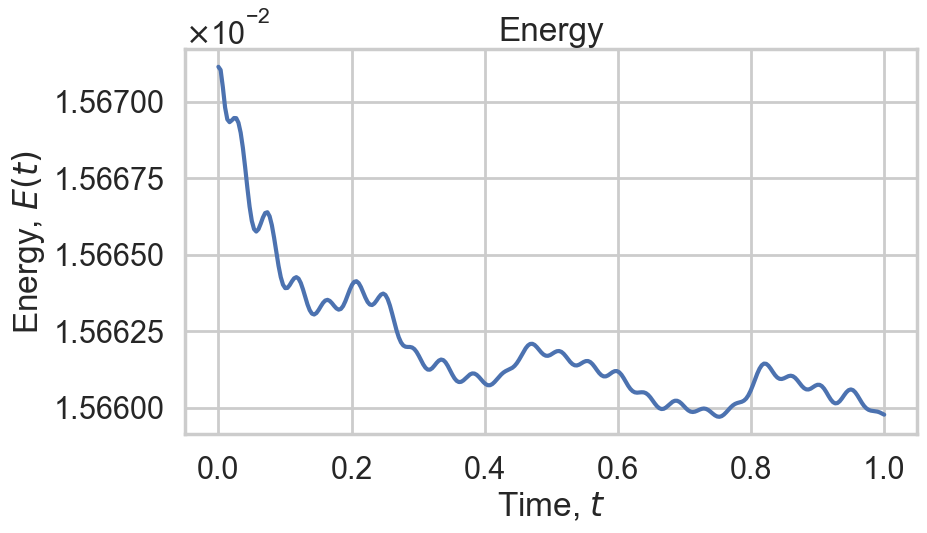

In [12]:
data = []
# Compute energy over time
for u, t in zip(u_sols, t_sols):
    energy = 0.5 * (u @ (solver.M_global @ u))
    data.append({
        "energy": energy,
        "time": t
    })
df = pd.DataFrame(data)


from matplotlib.ticker import ScalarFormatter

# Plot energy
fig = plt.figure(figsize=(9.45, 5))
ax = sns.lineplot(data=df, x="time", y="energy")

# Use scientific notationx   
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, -2))  # Force exponent -2
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel(r"Time, $t$")
ax.set_ylabel(r"Energy, $E(t)$") 

ax.set_title("Energy")

plt.savefig("report\output\energy_plot.png", bbox_inches='tight', dpi=400)
